<a href="https://colab.research.google.com/github/eyeaticha/skincancerclassify/blob/main/Classification_Skincancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown '15TJLOXAK2-Tz7HPGQxWZDvReNYBiDwoS'

Downloading...
From: https://drive.google.com/uc?id=15TJLOXAK2-Tz7HPGQxWZDvReNYBiDwoS
To: /content/skin_cancer_data.zip
100% 824M/824M [00:16<00:00, 51.3MB/s]


In [ ]:
!unzip "skin_cancer_data.zip"

Archive:  skin_cancer_data.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer ISIC The

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data as Data

In [ ]:
import cv2
import os
from glob import glob
import gc

In [ ]:
model_path = 'best_model.pt'

In [ ]:
data_transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

train_dataset = datasets.ImageFolder(root='Skin cancer ISIC The International Skin Imaging Collaboration/Train', transform=data_transform['train'])
val_dataset = datasets.ImageFolder(root='Skin cancer ISIC The International Skin Imaging Collaboration/Test', transform=data_transform['val'])

batch_size = 32
train_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = Data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
train_num = len(train_dataset)
val_num = len(val_dataset)
print("using {} images for training, {} images for validation.".format(train_num, val_num))

using 2239 images for training, 118 images for validation.


In [ ]:
class_count = {}
for image, label in train_dataset:
    if label in class_count:
        class_count[label] += 1
    else:
        class_count[label] = 1

for label, count in class_count.items():
    print("Class {}: {} examples".format(label, count))

Class 0: 114 examples
Class 1: 376 examples
Class 2: 95 examples
Class 3: 438 examples
Class 4: 357 examples
Class 5: 462 examples
Class 6: 77 examples
Class 7: 181 examples
Class 8: 139 examples


In [ ]:
class_count = {}
for image, label in train_dataset:
    class_name = train_dataset.classes[label]
    if class_name in class_count:
        class_count[class_name] += 1
    else:
        class_count[class_name] = 1

max = 0
for label, count in class_count.items():
    print("Class {}: {} examples".format(label, count)) 
    if count > max:
      baseline_class = count
      max = count

import numpy as np
from statistics import mode
baseline_acc = baseline_class / train_num
print("Baselie class:", baseline_class)
print("Baseline accuracy:", baseline_acc)


Class actinic keratosis: 114 examples
Class basal cell carcinoma: 376 examples
Class dermatofibroma: 95 examples
Class melanoma: 438 examples
Class nevus: 357 examples
Class pigmented benign keratosis: 462 examples
Class seborrheic keratosis: 77 examples
Class squamous cell carcinoma: 181 examples
Class vascular lesion: 139 examples
Baselie class: 462
Baseline accuracy: 0.20634211701652524


In [ ]:
from torch.utils.data import DataLoader,WeightedRandomSampler

# compute class weights
class_counts = [114, 376, 95, 438, 357, 462, 77, 181, 139] # example class counts
class_weights = 1.0 / torch.Tensor(class_counts)
sample_weights = [class_weights[label] for _, label in train_dataset]

# create sampler
sampler = WeightedRandomSampler(sample_weights, len(train_dataset), replacement=True)

# create data loader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

In [ ]:
# Define the ResNet50 model
from torchvision import models

class ResNet(nn.Module):
    def __init__(self, num_classes=9):
        super(ResNet, self).__init__()
        self.model = models.resnet50(pretrained=False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
# Initialize the ResNet50 model and move it to GPU
device = 'cuda'
net = ResNet(num_classes=9).to(device)

# Define the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Set the number of epochs and initialize variables to track the best accuracy and losses
epochs = 30
best_acc = 0.0
train_steps = len(train_loader)
losses = []
val_acces = []

# Train the model
for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    for step, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_func(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss / train_steps)
    
    torch.cuda.empty_cache()
    # Validate the model
    net.eval()
    acc = 0.0
    with torch.no_grad():
        for _, val_data in enumerate(val_loader):
            val_imgs, labels = val_data
            outputs = net(val_imgs.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, labels.to(device)).sum().item()        
    val_acc = acc / val_num
    val_acces.append(val_acc)
    
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_acc))

    # Save the model if the current validation accuracy is higher than the previous best
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(net.state_dict(), model_path)

print('Finished Training')
print("Best accuracy for validation: ", best_acc)

[epoch 1] train_loss: 1.626  val_accuracy: 0.237
[epoch 2] train_loss: 1.652  val_accuracy: 0.229
[epoch 3] train_loss: 1.620  val_accuracy: 0.254
[epoch 4] train_loss: 1.615  val_accuracy: 0.203
[epoch 5] train_loss: 1.616  val_accuracy: 0.263
[epoch 6] train_loss: 1.593  val_accuracy: 0.246
[epoch 7] train_loss: 1.623  val_accuracy: 0.305
[epoch 8] train_loss: 1.651  val_accuracy: 0.229
[epoch 9] train_loss: 1.617  val_accuracy: 0.220
[epoch 10] train_loss: 1.531  val_accuracy: 0.263
[epoch 11] train_loss: 1.584  val_accuracy: 0.263
[epoch 12] train_loss: 1.600  val_accuracy: 0.305
[epoch 13] train_loss: 1.610  val_accuracy: 0.322
[epoch 14] train_loss: 1.572  val_accuracy: 0.229
[epoch 15] train_loss: 1.602  val_accuracy: 0.271
[epoch 16] train_loss: 1.576  val_accuracy: 0.322
[epoch 17] train_loss: 1.554  val_accuracy: 0.305
[epoch 18] train_loss: 1.576  val_accuracy: 0.263


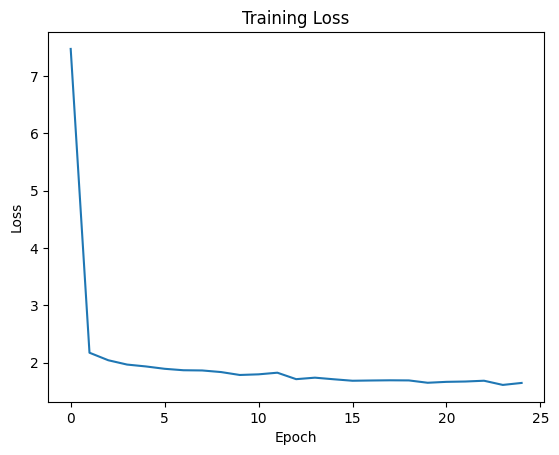

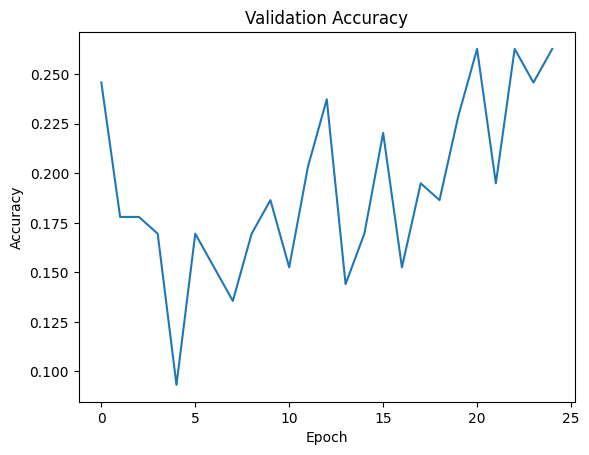

In [ ]:
import matplotlib.pyplot as plt

# Plot the training loss graph
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the validation accuracy graph
plt.plot(val_acces)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = []
pred_labels = []

for _, val_data in enumerate(val_loader):
    val_imgs, labels = val_data
    outputs = net(val_imgs.to(device))
    predict_y = torch.max(outputs, dim=1)[1]
    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(predict_y.cpu().numpy())
    acc += torch.eq(predict_y, labels.to(device)).sum().item()

In [ ]:
print(classification_report(true_labels, pred_labels))


              precision    recall  f1-score   support

           0       0.50      0.12      0.20        16
           1       0.33      0.38      0.35        16
           2       0.16      0.31      0.21        16
           3       0.00      0.00      0.00        16
           4       0.38      0.62      0.48        16
           5       0.17      0.12      0.14        16
           6       0.22      0.67      0.33         3
           7       0.33      0.06      0.11        16
           8       0.21      1.00      0.35         3

    accuracy                           0.26       118
   macro avg       0.26      0.37      0.24       118
weighted avg       0.27      0.26      0.22       118



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


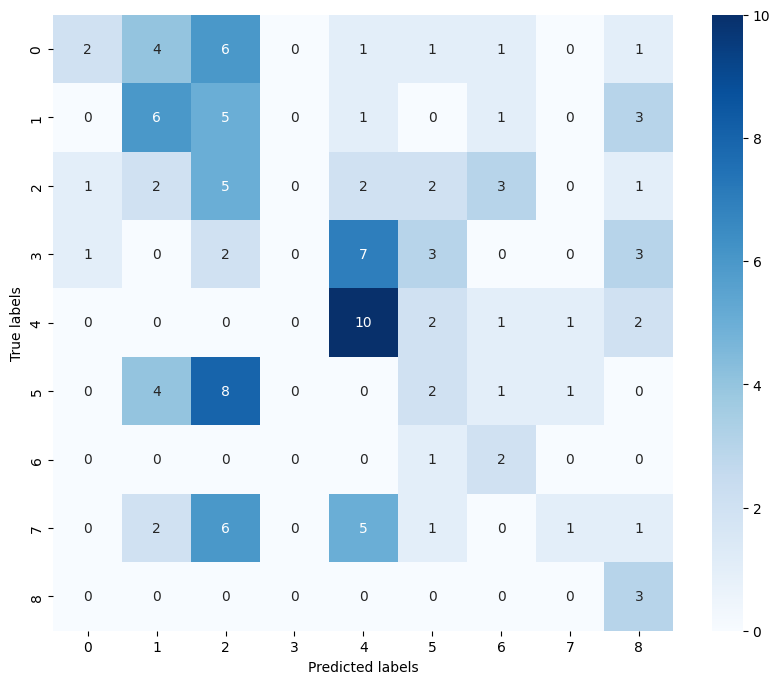

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [ ]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gradio as gr
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np

In [ ]:
#Load the saved PyTorch model
model_path = "best_model.pt"
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 9)

state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


_IncompatibleKeys(missing_keys=['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.conv3.weight', 'layer1.1.bn3.weight', 'layer1.1.bn3.bias', 'layer1.1.bn3.runni

In [ ]:
#Define the prediction function
def predict_image(img):
    # Convert NumPy array to PIL image // python image library
    img = Image.fromarray(np.uint8(img))

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0)

    # Make a prediction
    with torch.no_grad():
        outputs = model(img)
        probs = torch.softmax(outputs, dim=1)
    
    # Convert the tensor to a dictionary
    probs_dict = {f"class_{i}": prob.item() for i, prob in enumerate(probs[0])}
    probs_dict = {}
    for i, prob in enumerate(probs[0]):
        class_name = f"class_{i}"
        probs_dict[class_name] = prob.item()

#Change the class names
    probs_dict = {
    "actinic_keratosis": probs_dict["class_0"],
    "basal_cell_carcinoma": probs_dict["class_1"],
    "dermatofibroma": probs_dict["class_2"],
    "melanoma": probs_dict["class_3"],
    "nevus": probs_dict["class_4"],
    "pigmented_benign_keratosis": probs_dict["class_5"],
    "seborrheic_keratosis": probs_dict["class_6"],
    "squamous_cell_carcinoma": probs_dict["class_7"],
    "vascular_lesion": probs_dict["class_8"]
    }
    return probs_dict

#Define the input and output interfaces
input_interface = gr.inputs.Image(shape=(224, 224))
output_interface = gr.outputs.Label(num_top_classes=9)

#Create the web app in gradio
gr.Interface(fn=predict_image, inputs=input_interface, outputs=output_interface, 
             title="Skin Cancer Classifier", description="Classify images into 9 different Skin Cancer Type.").launch()


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>